In [1]:
import pyspark as ps
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, FloatType, IntegerType, ArrayType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import CountVectorizer, Tokenizer, HashingTF, StandardScaler, Normalizer
from pyspark.ml.feature import StopWordsRemover
import re
import matplotlib.pyplot as plt
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

In [2]:
spark = (
    ps.sql.SparkSession.builder
    .master("local[4]")
    .appName("project")
    .getOrCreate()
)

sc = spark.sparkContext

In [3]:
df = spark.read.json("ten_users1.json")
df = df.where(df['author'].isin(['dntletmygfknowimhere','Colin03129', 'jl_theprofessor', 'myKidsLike2Scream', 'a_frayn','QuoteMasterLT','glackbuy99']))

In [4]:
df1, df2 = df.randomSplit([0.5, 0.5])

In [5]:
df2.groupby('author').agg(F.count('body')).show()

+--------------------+-----------+
|              author|count(body)|
+--------------------+-----------+
|dntletmygfknowimhere|        301|
|          Colin03129|        372|
|     jl_theprofessor|       2655|
|   myKidsLike2Scream|        629|
|             a_frayn|       1000|
|       QuoteMasterLT|       1546|
|          glackbuy99|        541|
+--------------------+-----------+



In [6]:
df1.groupby('author').agg(F.count('body')).show()

+--------------------+-----------+
|              author|count(body)|
+--------------------+-----------+
|dntletmygfknowimhere|        337|
|          Colin03129|        384|
|     jl_theprofessor|       2689|
|   myKidsLike2Scream|        639|
|             a_frayn|       1085|
|       QuoteMasterLT|       1579|
|          glackbuy99|        461|
+--------------------+-----------+



In [7]:
comments1 = df1.groupBy("author").agg(F.collect_list("body"))
join_comments_udf = udf(lambda x: ' '.join(x), StringType())
df1_join_comments = comments1.withColumn('corpus', join_comments_udf(comments1['collect_list(body)']))

In [8]:
def count_links(s):
    num_links = len(re.findall(r'\(http.+\)', s)[0].split(')('))
    return num_links
count_links_udf = udf(count_links, IntegerType())
df_count_links1 = df1_join_comments.withColumn(
    'link_count', count_links_udf(df1_join_comments['corpus']))


In [9]:
def drop_links(s):
    return re.sub(r'\(http.+\)', '', s)
drop_links_udf = udf(drop_links, StringType())
df_drop_links1 = df_count_links1.withColumn('corpus', drop_links_udf(df_count_links1['corpus']))

In [10]:
df_drop_links1.show(5)

+--------------------+--------------------+--------------------+----------+
|              author|  collect_list(body)|              corpus|link_count|
+--------------------+--------------------+--------------------+----------+
|dntletmygfknowimhere|[

Pro: making

C...|

Pro: making

Co...|         1|
|          Colin03129|[###Environmental...|###Environmental ...|         1|
|     jl_theprofessor|[


The WAU is Ir...|


The WAU is Irr...|         1|
|   myKidsLike2Scream|[ he said Pterry ...| he said Pterry i...|         1|
|             a_frayn|["Don't you hate ...|"Don't you hate p...|         1|
+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [11]:
def tokenize(s):
    s = s.lower()
    token = TweetTokenizer()
    return token.tokenize(s)

tokenize_udf = udf(tokenize, ArrayType(StringType()))
df_tokens1 = df_drop_links1.withColumn('tokens', tokenize_udf(df_drop_links1['corpus']))

In [12]:
def find_words(s):
    return [i for i in s if i.isalpha()]
        
find_words_udf = udf(find_words, ArrayType(StringType()))
df_find_words1 = df_tokens1.withColumn('words', find_words_udf(df_tokens1['tokens']))

In [13]:
def word_length(words):
    return [len(word) for word in words]

word_length_udf = udf(word_length, ArrayType(IntegerType()))
word_length_df1 = df_find_words1.withColumn('word_lengths', word_length_udf(df_find_words1['words']))
total_words_udf = udf(lambda x: len(x), IntegerType())
total_words_df1 = word_length_df1.withColumn('total_words', total_words_udf(word_length_df1['words']))

In [14]:
total_words_df1.show(5)

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+-----------+
|              author|  collect_list(body)|              corpus|link_count|              tokens|               words|        word_lengths|total_words|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+-----------+
|dntletmygfknowimhere|[

Pro: making

C...|

Pro: making

Co...|         1|[pro, :, making, ...|[pro, making, con...|[3, 6, 3, 4, 3, 2...|       7350|
|          Colin03129|[###Environmental...|###Environmental ...|         1|[###environmental...|[protection, envi...|[10, 13, 7, 3, 8,...|       8407|
|     jl_theprofessor|[


The WAU is Ir...|


The WAU is Irr...|         1|[the, wau, is, ir...|[the, wau, is, ir...|[3, 3, 2, 12, 5, ...|      61056|
|   myKidsLike2Scream|[ he said Pterry ...| he said Pterry i...|         1|[he, said, pterry..

In [15]:
stops = stopwords.words('english')
x = [i.split("'")for i in stops]
stops = [i[0] for i in x]
stops = list(set(stops))
def stop_words_filter(s):
    return [i for i in s if i in stops]
stop_words_udf = udf(stop_words_filter, ArrayType(StringType()))
df_stop_words1 = total_words_df1.withColumn('stop_words', stop_words_udf(total_words_df1['words']))

In [16]:
hashingTF = HashingTF(numFeatures=153, inputCol='stop_words', outputCol='features')
tf1 = hashingTF.transform(df_stop_words1)
tf_norm1 = Normalizer(inputCol="features", outputCol="features_norm", p=1).transform(tf1)
tf_norm1.show

<bound method DataFrame.show of DataFrame[author: string, collect_list(body): array<string>, corpus: string, link_count: int, tokens: array<string>, words: array<string>, word_lengths: array<int>, total_words: int, stop_words: array<string>, features: vector, features_norm: vector]>

In [17]:
tf_norm1_ex = tf_norm1.select('author','features_norm')
tf_norm1_ex.show(3,False)

+--------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [18]:
stdscaler = StandardScaler(inputCol='features_norm', outputCol='scaled', withMean=True)
scale_fit1 = stdscaler.fit(tf_norm1)
scaled1 = scale_fit1.transform(tf_norm1)

In [19]:
common_words1 = scaled1.select('author', 'scaled')

In [20]:
common_words1.show(3, False)

+--------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

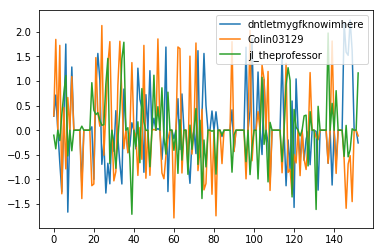

In [21]:
counter = 0
for i in common_words1.rdd.collect():
    counter +=1
    if counter > 3:
        break
    plt.plot(i[1], label=i[0])
plt.legend()


In [22]:
comments2 = df2.groupBy("author").agg(F.collect_list("body"))
join_comments_udf = udf(lambda x: ' '.join(x), StringType())
df2_join_comments = comments2.withColumn('corpus', join_comments_udf(comments2['collect_list(body)']))

In [23]:
def count_links(s):
    num_links = len(re.findall(r'\(http.+\)', s)[0].split(')('))
    return num_links
count_links_udf = udf(count_links, IntegerType())
df_count_links2 = df2_join_comments.withColumn(
    'link_count', count_links_udf(df2_join_comments['corpus']))


In [24]:
def drop_links(s):
    return re.sub(r'\(http.+\)', '', s)
drop_links_udf = udf(drop_links, StringType())
df_drop_links2 = df_count_links2.withColumn('corpus', drop_links_udf(df_count_links2['corpus']))

In [25]:
def tokenize(s):
    s = s.lower()
    token = TweetTokenizer()
    return token.tokenize(s)

tokenize_udf = udf(tokenize, ArrayType(StringType()))
df_tokens2 = df_drop_links2.withColumn('tokens', tokenize_udf(df_drop_links2['corpus']))

In [26]:
def find_words(s):
    return [i for i in s if i.isalpha()]
        
find_words_udf = udf(find_words, ArrayType(StringType()))
df_find_words2 = df_tokens2.withColumn('words', find_words_udf(df_tokens2['tokens']))

In [27]:
def word_length(words):
    return [len(word) for word in words]

word_length_udf = udf(word_length, ArrayType(IntegerType()))
word_length_df2 = df_find_words2.withColumn('word_lengths', word_length_udf(df_find_words2['words']))
total_words_udf = udf(lambda x: len(x), IntegerType())
total_words_df2 = word_length_df2.withColumn('total_words', total_words_udf(word_length_df2['words']))

In [28]:
stops = stopwords.words('english')
x = [i.split("'")for i in stops]
stops = [i[0] for i in x]
stops = list(set(stops))


def stop_words_filter(s):
    return [i for i in s if i in stops]

In [29]:
stop_words_udf = udf(stop_words_filter, ArrayType(StringType()))
df_stop_words2 = total_words_df2.withColumn('stop_words', stop_words_udf(total_words_df2['words']))

In [30]:
hashingTF = HashingTF(numFeatures=153, inputCol='stop_words', outputCol='features')
tf2 = hashingTF.transform(df_stop_words2)
tf_norm2 = Normalizer(inputCol="features", outputCol="features_norm", p=1).transform(tf2)

In [31]:
stdscaler = StandardScaler(inputCol='features_norm', outputCol='scaled',withMean=True)
scale_fit2 = stdscaler.fit(tf_norm2)
scaled2 = scale_fit2.transform(tf_norm2)

In [32]:
common_words2 = scaled2.select('author', 'scaled')

In [33]:
common_words2.show(3, False)

+--------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

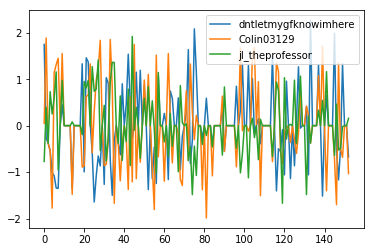

In [34]:
counter = 0
for i in common_words2.rdd.collect():
    counter +=1
    if counter > 3:
        break
    plt.plot(i[1], label=i[0])
plt.legend()

In [41]:
similarities = {}
for p in common_words1.rdd.collect():
    row = p[1]
    cosines = {}
    for i in common_words2.rdd.collect():
        cos = (row.dot(i[1])/ (row.norm(2)*i[1].norm(2)))
        cosines[i[0]] = cos
    similarities[p[0]] = cosines

In [42]:
similarities

{'dntletmygfknowimhere': {'dntletmygfknowimhere': 0.4797220787598792,
  'Colin03129': -0.05290291988208169,
  'jl_theprofessor': -0.3003300772727356,
  'myKidsLike2Scream': 0.19941811534902526,
  'a_frayn': -0.34524095176750774,
  'QuoteMasterLT': 0.1549397777060208,
  'glackbuy99': -0.2658730636499266},
 'Colin03129': {'dntletmygfknowimhere': -0.1473050340722967,
  'Colin03129': 0.6555632564650069,
  'jl_theprofessor': 0.1570983759989851,
  'myKidsLike2Scream': -0.45539929714114075,
  'a_frayn': 0.027428319166693835,
  'QuoteMasterLT': -0.17086929412955792,
  'glackbuy99': -0.10258616855980468},
 'jl_theprofessor': {'dntletmygfknowimhere': -0.2379404386141652,
  'Colin03129': 0.08248566775933744,
  'jl_theprofessor': 0.7308661694804133,
  'myKidsLike2Scream': -0.2549006960322795,
  'a_frayn': 0.03803276318283652,
  'QuoteMasterLT': -0.25484888278417345,
  'glackbuy99': 0.038181937370602444},
 'myKidsLike2Scream': {'dntletmygfknowimhere': 0.19542620713567807,
  'Colin03129': -0.3313779

In [44]:
import pandas as pd
df1 = pd.DataFrame(similarities)

In [45]:
df1

,dntletmygfknowimhere,Colin03129,jl_theprofessor,myKidsLike2Scream,a_frayn,QuoteMasterLT,glackbuy99
Colin03129,-0.052903,0.655563,0.082486,-0.331378,-0.158963,-0.285890,-0.026529
QuoteMasterLT,0.154940,-0.170869,-0.254849,0.032241,-0.353146,0.719220,-0.258704
a_frayn,-0.345241,0.027428,0.038033,-0.114266,0.640568,-0.388928,0.243794
dntletmygfknowimhere,0.479722,-0.147305,-0.237940,0.195426,-0.319552,0.116642,-0.143043
glackbuy99,-0.265873,-0.102586,0.038182,-0.335249,0.172875,-0.061177,0.557927
jl_theprofessor,-0.300330,0.157098,0.730866,-0.163513,0.149126,-0.344000,-0.066554
myKidsLike2Scream,0.199418,-0.455399,-0.254901,0.651967,-0.009725,0.208100,-0.257182


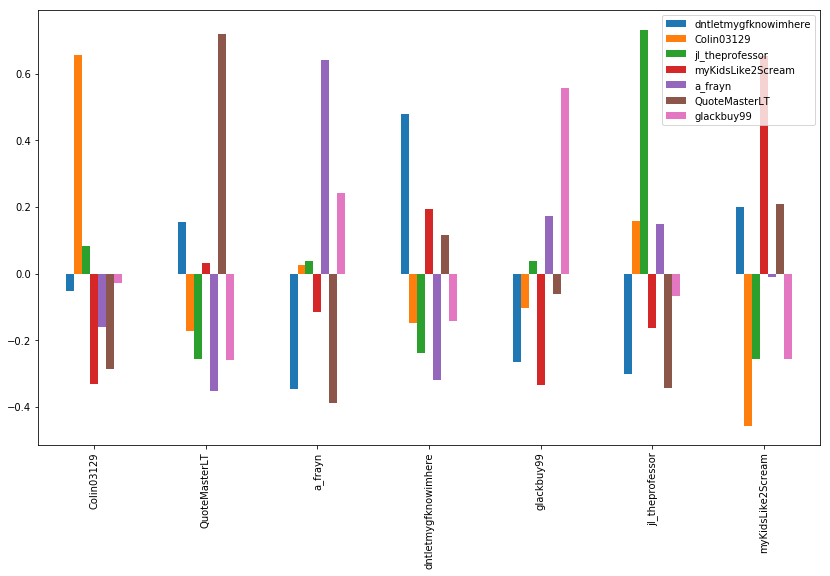

In [46]:
df1.plot(kind='bar', figsize=(14,8))

In [25]:
#find RMSE for each of the users
word_lengths = {}
for key, value in word_freqs1.items():
    error_values = {}
    for k, v in word_freqs2.items():
        rmse = np.mean(np.sqrt((v-value)**2))
        error_values[k] = rmse
    word_lengths[key] = error_values

In [26]:
word_lengths

{'dntletmygfknowimhere': {'dntletmygfknowimhere': 0.0030415574489097443,
  'Colin03129': 0.007232809414484562,
  'jl_theprofessor': 0.008962843649411339,
  'myKidsLike2Scream': 0.0020878993589796527,
  'a_frayn': 0.005536804331713035,
  'QuoteMasterLT': 0.0028537407947247548,
  'glackbuy99': 0.007668906664840056},
 'Colin03129': {'dntletmygfknowimhere': 0.007094167725391774,
  'Colin03129': 0.0030001517422287237,
  'jl_theprofessor': 0.005509181308394059,
  'myKidsLike2Scream': 0.008153599327053375,
  'a_frayn': 0.0041590397691140335,
  'QuoteMasterLT': 0.009367181116347045,
  'glackbuy99': 0.00651988185554512},
 'jl_theprofessor': {'dntletmygfknowimhere': 0.00668470388711838,
  'Colin03129': 0.003452422002464113,
  'jl_theprofessor': 0.0013576856573640427,
  'myKidsLike2Scream': 0.008454504079201976,
  'a_frayn': 0.004263740050613655,
  'QuoteMasterLT': 0.008680802900150048,
  'glackbuy99': 0.006575814423450375},
 'myKidsLike2Scream': {'dntletmygfknowimhere': 0.0036062111612501337,
  

In [27]:
import pandas as pd

In [28]:
df = pd.DataFrame(word_lengths)

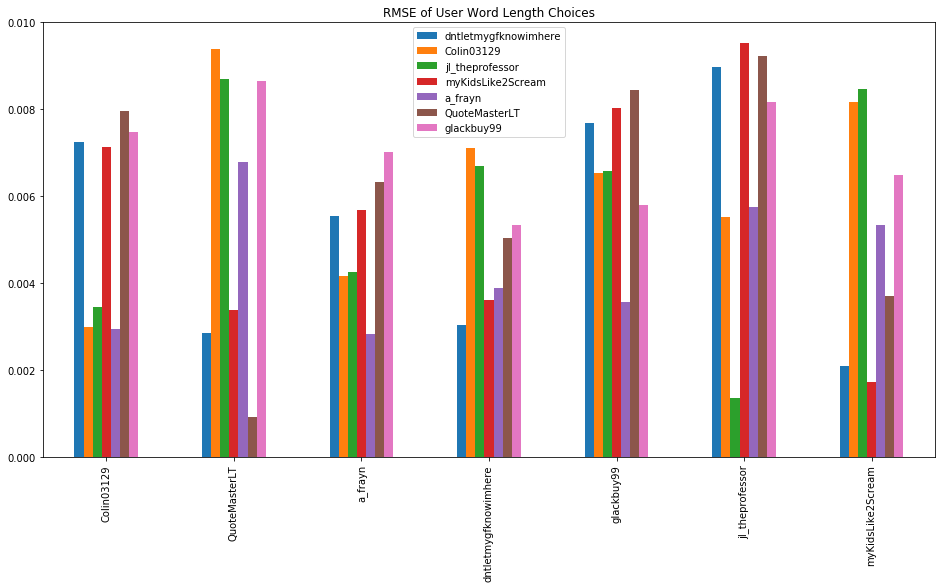

In [41]:
ax = df.plot(kind='bar', figsize=(16,8), title='RMSE of User Word Length Choices')
fig = ax.get_figure()
fig.savefig('word_length_errors.png')


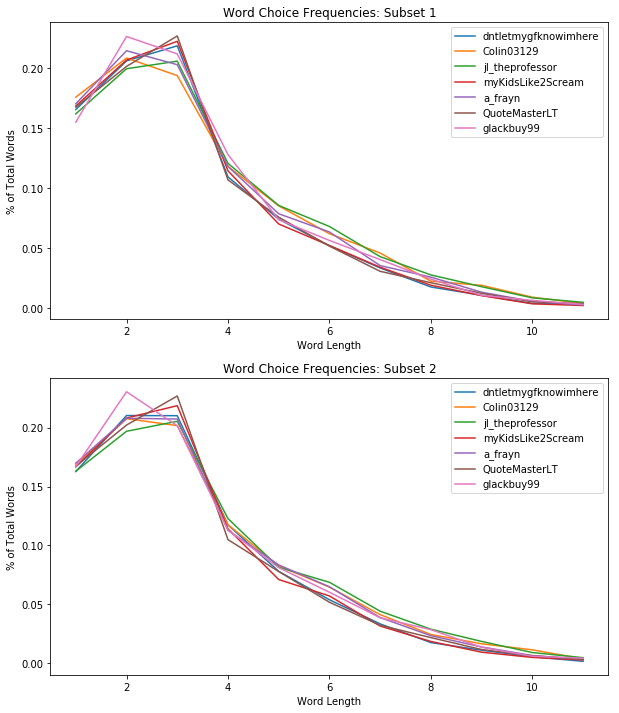

In [40]:
fig, ax = plt.subplots(2,1,figsize=(10,12))
for key, value in word_freqs1.items():
    ax[0].plot(range(1,12), value, label=key)
ax[0].set_ylabel('% of Total Words')
ax[0].set_xlabel('Word Length')
ax[0].set_title('Word Choice Frequencies: Subset 1')
ax[0].legend()
for key, value in word_freqs2.items():
    ax[1].plot(range(1,12), value, label=key)
ax[1].set_ylabel('% of Total Words')
ax[1].set_xlabel('Word Length')
ax[1].set_title('Word Choice Frequencies: Subset 2')
ax[1].legend()
fig.savefig('word_lengths.png', bbox_inches='tight')

In [44]:
df

,dntletmygfknowimhere,Colin03129,jl_theprofessor,myKidsLike2Scream,a_frayn,QuoteMasterLT,glackbuy99
Colin03129,0.007233,0.003000,0.003452,0.007119,0.002946,0.007963,0.007483
QuoteMasterLT,0.002854,0.009367,0.008681,0.003394,0.006780,0.000918,0.008650
a_frayn,0.005537,0.004159,0.004264,0.005678,0.002822,0.006316,0.007012
dntletmygfknowimhere,0.003042,0.007094,0.006685,0.003606,0.003890,0.005040,0.005345
glackbuy99,0.007669,0.006520,0.006576,0.008016,0.003574,0.008447,0.005803
jl_theprofessor,0.008963,0.005509,0.001358,0.009513,0.005757,0.009213,0.008168
myKidsLike2Scream,0.002088,0.008154,0.008455,0.001719,0.005342,0.003705,0.006481
